## pandahub IO methods

This tutorial briefly demonstrates how to use the pandahub IO methods. This includes high level functions for commonly used database interactions like reading and writing grid data or timeseries data from/to a MongoDB database. pandahub IO methods do not need any additional configuration. Just call a pandahub API object (see the `01_pandahub API - interaction with a MongoDB database tutorial`) and directly use its IO interaction methods.

>**Note**
>
>To run this tutorial you need a config file containing the database server URL and authentification information (For more information check out the tutorial `01_pandahub API - interaction with a MongoDB database tutorial`)

# 1. Call pandahub api and activate project

In [1]:
# At first we need to call a pandahub API object
import pandahub as ph
from config import MONGODB_URL

ph_api = ph.PandaHub(connection_url=MONGODB_URL)

hp.pandapower.plotting.plotly.traces - INFO: Failed to import plotly - interactive plotting will not be available


In a next step, check if your project, you want to interact with, exists. If so, we activate the particular project. 

>**Note**
>
>If not, you need to create the project first. If you don't know how to do that, please check out '01_pandahub API - call a MongoDB database'):

In [2]:
ph_api.project_exists('MyAwesomeFirstProject')

True

In [3]:
ph_api.set_active_project('MyAwesomeFirstProject')

In the next section, you finally are able to work with your database.

# 2. Interaction with the MongoDB database

This is an example how to write and read a pandapower/pandapipes net as well as timeseries data. If `return_id` is set to True, the method returns the unique identifier of the document that is written to the database. You can also add custom kwargs.

### Write/Read a pandapower/pandapipes net

In this subsection, we explain how to write and read pandapower and pandapipes networks.

**pandapower**

At first we need to load a pandapower net. In our example we load the `mv_oberrhein` network.

In [4]:
from pandapower import networks as nws

net_orig = nws.mv_oberrhein()

hp.pandapower.auxiliary - WARNING: numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



This net looks like follows:

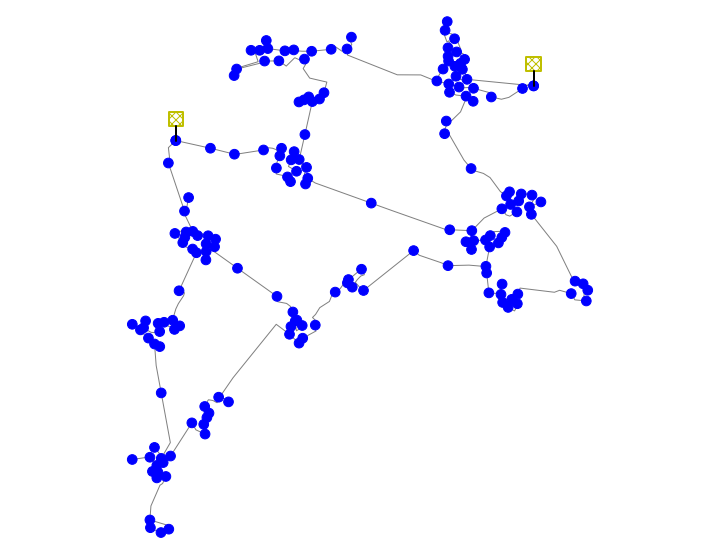

(<AxesSubplot:>,
  (<matplotlib.collections.PatchCollection at 0x1cb3a255d30>,
   <matplotlib.collections.LineCollection at 0x1cb3c2be220>),
  (<matplotlib.collections.PatchCollection at 0x1cb3c2c2280>,
   <matplotlib.collections.LineCollection at 0x1cb3c2c24c0>),
  (<matplotlib.collections.PatchCollection at 0x1cb3a255dc0>,
   <matplotlib.collections.LineCollection at 0x1cb3c2bed30>)])

In [5]:
from pandapower.plotting import simple_plot

simple_plot(net_orig)

As next step, we write the net to our database we just activated before. 

In [6]:
ph_api.write_network_to_db(net_orig, 'MyAwesomeNet')

Wrting a net to our database, each pandas DataFrame is written into a corresponding collection. General information of a net is saved under `_networks`.

Besides the way described above, there is another alternative way to write a network to the database. 
Instead of activating your project like described in section 1, you are also able to directly pass the `project id` within the `write_network_to_db` function. Doing so, the project gets activated automatically. To show this, we again call the pandahub api first.

In [7]:
ph_api = ph.PandaHub(connection_url=MONGODB_URL)

If you try to write the net to the database now, you get the error message, that the project is not activated:

In [8]:
ph_api.write_network_to_db(net_orig, 'MyAwesomeNet')

PandaHubError: No project is activated

However, as soon as you pass a `project id`, the project gets activated on the fly:

In [9]:
ph_api.write_network_to_db(net_orig, 'MyAwesomeNet', project_id='Awesome')

The net is now saved in the database and can be called:

In [10]:
net_db = ph_api.get_net_from_db('MyAwesomeNet')

Comparing the original net with the net retrieved from the database shows that both nets are equal:

In [11]:
import pandapower as pp
from pandapower.toolbox import nets_equal

pp.runpp(net_db)
pp.runpp(net_orig)

nets_equal(net_orig, net_db, check_only_results=True)

hp.pandapower.auxiliary - WARNING: numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

hp.pandapower.auxiliary - WARNING: numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



True

Instead of writing a net to or reading a net from a database, it is also possible to just call and modify single values. Reading a single value can be done by calling following function:

In [12]:
ph_api.get_net_value_from_db('MyAwesomeNet', 'load', 0, 'p_mw')

0.25

To change this value, you need to call following function:

In [13]:
ph_api.set_net_value_in_db('MyAwesomeNet', 'load', 0, 'p_mw', 0.5)

SET MyAwesomeNet load 0 p_mw 0.5


Calling the value again, shows that the value has been modified:

In [14]:
ph_api.get_net_value_from_db('MyAwesomeNet', 'load', 0, 'p_mw')

0.5

**pandapipes**

Likewise as in the pandapower example, we need to load a pandapipes networks first. We could have chosen a network with georeferenced data points, however, there is no network example given covering most of the pandapipes components. Therefore we chose a generic network.

In [15]:
from pandapipes import networks as nws

net_orig = nws.gas_versatility()

As next step we upload the net to our database:

In [16]:
ph_api.write_network_to_db(net_orig, 'MyAwesomePandapipesNet')

Retrieving this net from the database again and comparing it to the original networks leads to same results:

In [17]:
import pandapipes as pps
from pandapipes.toolbox import nets_equal

net_db = ph_api.get_net_from_db('MyAwesomePandapipesNet')

pps.pipeflow(net_db)
pps.pipeflow(net_orig)

nets_equal(net_orig, net_db, check_only_results=True)

hp.pandapipes.component_models.pump_component - ERROR: Molar mass is missing in your fluid. Before you are able to retrieve the compression power make sure that the molar mass is defined
hp.pandapipes.component_models.pump_component - ERROR: Molar mass is missing in your fluid. Before you are able to retrieve the compression power make sure that the molar mass is defined


True

### Write/Read a time series

The procedure to call a single or multiple time series diverge. The differences are hightlighted in the following:

**Single time series**

At first, we call the pandahub api again:

In [ ]:
ph_api = ph.PandaHub(connection_url=MONGODB_URL)

If you want to write a time series to the pandahub database, you need to ask yourself, if the time series shall be globally or project specific available. If you define it globally, you can access the time series without calling a specific project. 

In the following, we show how to upload a randomly created time series for global use. If you assign it project specific, you need to pass a `project_id` or activate a project beforehand.

In [ ]:
import pandas as pd
import numpy as np

timeseries_data = pd.Series(np.random.random(35040))
ph_api.write_timeseries_to_db(timeseries_data, 
                              data_type='p_mw', 
                              collection_name="timeseries", 
                              global_database=True, 
                              compress_ts_data=False)

Passing the time series data you need to define a data type. The recommended format is `<type>_<unit>`. Moreover, you can also compress your time series data. The main advantages of compressing your data are, that you can read time series from and write time series to the data base much faster. Furthermore, the time series occupies much less space. However, you should also always keep the drawbacks in mind. To make use of the advantages, the time series are saved as bytestring. Thus, compressed they are not human readable anymore. Furthmore, filter functionalities are not working. Therefore, you always need to call the entire time series. You cannot only read some parts of it. Especially, for web applications is usually does not make much sense to compress your data.

To call the time series, use following function:

In [ ]:
ph_api.get_timeseries_from_db(filter_document={'data_type':'p_mw'}, 
                              collection_name="timeseries", 
                              global_database=True,
                              compressed_ts_data=False)

Within the `filter_document` dict you can pass everything you want. The database matching the filter criteria are extracted accordingly.

If you want, you can also extract the time series metadata. Just set `include_metadata` equal to True

In [ ]:
ph_api.get_timeseries_from_db(filter_document={'data_type':'p_mw'}, 
                              collection_name="timeseries", 
                              global_database=True,
                              compressed_ts_data=False, 
                              include_metadata=True)

Et voilà, you are now able to save and call time series in pandahub!

**multiple time series**

In case of calling multiple time series the procedure is slightly different compare to a single time series. At first, we add a second time series:

In [ ]:
timeseries_data = pd.Series(np.random.random(35040))
ph_api.write_timeseries_to_db(timeseries_data, 
                              data_type='p_mw', 
                              collection_name="timeseries", 
                              global_database=True, 
                              compress_ts_data=False)

Trying to get the time series with the function above leads to following error:

In [ ]:
ph_api.get_timeseries_from_db(filter_document={'data_type':'p_mw'}, 
                              collection_name="timeseries", 
                              global_database=True,
                              compressed_ts_data=False, 
                              include_metadata=True)

If you still want to retrieve both time series, you need to call another function:

In [ ]:
ph_api.multi_get_timeseries_from_db(filter_document={'data_type':'p_mw'}, 
                                    collection_name="timeseries", 
                                    global_database=True,
                                    compressed_ts_data=False, 
                                    include_metadata=True)

Using the function above, you are now able to get all time series matching the filter criteria above and do your postprocessing apart from the database.